# DC2: Generate Postage Stamps (Cutouts) for objects in the Object Catalog

Owner: **Yao-Yuan Mao** ([@yymao](https://github.com/LSSTDESC/DC2-analysis/issues/new?body=@yymao))
<br>Last Verified to Run: **2020-11-30** (by @yymao)

This notebook is partly based on the `dm_butler_postage_stamps` notebook by Michael Wood-Vasey and the Stack Club `ButlerTutorial` by Daniel Perrefort.

In this notebook, we will first obtain a list of RA, Dec positions from the Object catalog using [GCRCatalogs](https://github.com/LSSTDESC/gcr-catalogs/), and then generate "postage-stamp" cutout images from the coadded images. 

### Learning Objectives:
After working through and studying this Notebook you should be able to
   1. Find the corresponding tracts and patches for a given list of RA and Dec
   2. Generate a postage stamp from a coadd for your chosen RA, Dec in a chosen filter, using matplotlib
   3. Obtain cutout images in two different ways ( `.getCutout()` and `butler.get(bbox=..)` )   
   4. Generate false color RGB images

### Logistics
This is intended to be runnable at NERSC through the https://jupyter.nersc.gov interface from a local git clone of https://github.com/LSSTDESC/DC2-analysis in your NERSC directory.  But you can also run it wherever, with appropriate adjustment of the 'repo' location to point to a place where you have a Butler repo will all of the images. 

This notebook uses the `desc-stack-weekly-latest` kernel. Instructions for setting up the proper DESC python kernel can be found here: https://confluence.slac.stanford.edu/x/o5DVE

## Set up

First we will load the needed modules and DC2 DR6 data sets: object catalogs (with `GCRCatalogs`) and DRP products (with `desc_dc2_dm_data`).

In [4]:
# A few common packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# We will use astropy's WCS and ZScaleInterval for plotting
from astropy.wcs import WCS
from astropy.visualization import ZScaleInterval

# We will use several stack functions
import lsst.geom
import lsst.afw.display as afwDisplay
import lsst.afw.display.rgb as rgb

# And also DESC packages to get the data path
import GCRCatalogs
from GCRCatalogs import GCRQuery
import desc_dc2_dm_data

If you are on a custom kernel (i.e., not using a DESC kernel), and you do have stack installed, but not those DESC packages.
You can install them by uncomment and running the following cell.

In [56]:
## Uncomment and run this cell *only if* you are on a custom kernel that has stack installed, but not the DESC packages 

#%pip install https://github.com/LSSTDESC/gcr-catalogs/archive/master.zip
#%pip install https://github.com/LSSTDESC/desc-dc2-dm-data/archive/master.zip

In [5]:
sorted(desc_dc2_dm_data.REPOS)

['1.1p',
 '1.2i',
 '1.2p',
 '1.2p_v3',
 '1.2p_v4',
 '2.1i',
 '2.1i_dr1a',
 '2.1i_dr1b',
 '2.1i_dr4',
 '2.1i_v1',
 '2.2i_dia_y2_t3828',
 '2.2i_dr2_tract3828',
 '2.2i_dr3',
 '2.2i_dr6_wfd',
 'dia_2020Jan']

We will be using the DC2 Run 2.2i DR6 WFD data. Read more about this data set here: https://arxiv.org/abs/2010.05926

In [6]:
dc2_data_version = "2.2i_dr6_wfd"

In [7]:
GCRCatalogs.get_available_catalogs(names_only=True, name_contains=dc2_data_version)

['dc2_object_run2.2i_dr6_wfd',
 'dc2_object_run2.2i_dr6_wfd_matched_addon',
 'dc2_object_run2.2i_dr6_wfd_with_metacal']

In [8]:
cat = GCRCatalogs.load_catalog("dc2_object_run"+dc2_data_version)

In [9]:
butler = desc_dc2_dm_data.get_butler(dc2_data_version)

## Get list of tracts

In [10]:
ra0=59.38
dec0=-28.57

In [11]:
from astropy.coordinates import SkyCoord 

In [12]:
c = SkyCoord(ra0, dec0, unit="deg")

In [13]:
c.ra.hms  

hms_tuple(h=3.0, m=57.0, s=31.200000000003598)

In [149]:
ra0/360*24

3.958666666666667

In [150]:
(ra0/360*24-3)*60

57.52000000000001

In [151]:
((ra0/360*24-3)*60-57)*60

31.200000000000614

In [14]:
c.dec.dms

dms_tuple(d=-28.0, m=-34.0, s=-12.000000000001023)

In [15]:
# Query all available tracts, only displays the first 5
tracts_list=cat.available_tracts

In [68]:
#tracts_list[:]

In [ ]:
for tract_id in tracts_list:
        myselection = 'tract=={}'.format(tract_id)
        mydata = cat.get_quantities(['ra', 'dec'], native_filters=[myselection])
        if len(mydata)>0:
            ramin=mydata['ra'].min()
            ramax=mydata['ra'].max()
            decmin=mydata['dec'].min()
            decmax=mydata['dec'].max()
            print("{} : {}  < ra  < {} , {} < dec < {}".format(tract_id,ramin,ramax,decmin,decmax))
        
            if ramin<ra0 and ramax>ra0 and decmin<dec0 and decmax>dec0:
                print("the tract to select id",tract_id)
                tract_id_sel=tract_id

2723 : 49.75174698176389  < ra  < 50.93792437826455 , -44.64227902879076 < dec < -44.628164702236866
2724 : 51.0120386201946  < ra  < 53.06305513793274 , -44.64304768475243 < dec < -44.62811119380345
2725 : 53.07270298478843  < ra  < 55.13892030862005 , -44.642379839434035 < dec < -44.62810534390525
2726 : 55.14812832386915  < ra  < 57.158116902736054 , -44.64469552262338 < dec < -44.628101609382085
2727 : 57.225993859705746  < ra  < 59.16643840220496 , -44.64369804966481 < dec < -44.62810781077738
2728 : 59.348010112137345  < ra  < 61.33751892867569 , -44.64198207081756 < dec < -44.628132277079885
2729 : 61.40258823801923  < ra  < 63.44705872542085 , -44.643355293846895 < dec < -44.6281268244346
2730 : 63.47965282162293  < ra  < 65.54496295500907 , -44.64091549743456 < dec < -44.628107407156
2731 : 65.55136809126752  < ra  < 67.55920606536598 , -44.642587097415955 < dec < -44.628107346020585
2732 : 67.6710835787208  < ra  < 69.69229579436427 , -44.642494553568056 < dec < -44.628100309

## Get a list of interesting objects

Here we will find some brightest galaxies in the object catalog to make cutout images for them! 

To learn what columns are in the object catalogs, refer to [this schema table](https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/SCHEMA.md#schema-for-dc2-object-catalogs). And sometimes it'd be helpful to look at the [source code](https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/dc2_object.py#L341).

In [16]:
bright_galaxy_query = GCRQuery(
    "clean",
    "extendedness == 1",
    "mag_r_cModel < 16",
    "snr_g_cModel > 10",
    "snr_r_cModel > 10",
    "snr_i_cModel > 10",
)

In [17]:
columns_to_get = ["objectId", "ra", "dec", "mag_r_cModel", "tract", "patch"]
assert cat.has_quantities(columns_to_get)

# Here we use native_filters to limit to tract == 4639 to save some load time

objects = cat.get_quantities(columns_to_get, filters=bright_galaxy_query, native_filters="tract == 4852")
objects  # get_quantities returns an ordinary python dictionary

/opt/lsst/software/stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/GCRCatalogs/dc2_dm_catalog.py:44: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky
/opt/lsst/software/stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/GCRCatalogs/dc2_dm_catalog.py:44: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky


{'tract': array([4852, 4852, 4852, 4852, 4852, 4852, 4852, 4852, 4852, 4852, 4852,
        4852, 4852, 4852, 4852, 4852, 4852, 4852]),
 'ra': array([59.68804339, 59.63386898, 59.64473094, 59.60709071, 59.10970552,
        58.8791605 , 58.99867797, 58.90541341, 58.97380005, 58.66060148,
        58.63677701, 58.73902712, 58.39042619, 58.38871333, 58.3139574 ,
        58.36692077, 58.28433613, 58.09885039]),
 'objectId': array([21339321671910863, 21339325966884262, 21339325966884263,
        21339343146755871, 21339600844795223, 21339733988767496,
        21339738283731803, 21339742578716236, 21339759758580361,
        21339875722697305, 21339884312619659, 21339892902570417,
        21340008866672484, 21340008866679940, 21340017456620905,
        21340021751584276, 21340026046552706, 21340154895568203]),
 'patch': array(['0,0', '0,1', '0,1', '0,5', '2,1', '3,0', '3,1', '3,2', '3,6',
        '4,1', '4,3', '4,5', '5,0', '5,0', '5,2', '5,3', '5,4', '6,2'],
       dtype=object),
 'mag_r_cMode

In [19]:
# make it a pandas data frame for the ease of manipulation
objects = pd.DataFrame(objects)
objects

tract         ra           objectId patch  mag_r_cModel        dec
0    4852  59.688043  21339321671910863   0,0     15.058875 -29.669538
1    4852  59.633869  21339325966884262   0,1     15.573633 -29.368290
2    4852  59.644731  21339325966884263   0,1     15.962490 -29.372153
3    4852  59.607091  21339343146755871   0,5     15.766623 -28.473613
4    4852  59.109706  21339600844795223   2,1     15.328131 -29.350510
5    4852  58.879160  21339733988767496   3,0     15.803582 -29.718161
6    4852  58.998678  21339738283731803   3,1     15.226345 -29.542988
7    4852  58.905413  21339742578716236   3,2     15.490280 -29.148905
8    4852  58.973800  21339759758580361   3,6     14.999232 -28.298503
9    4852  58.660601  21339875722697305   4,1     15.570794 -29.392947
10   4852  58.636777  21339884312619659   4,3     15.291357 -29.087433
11   4852  58.739027  21339892902570417   4,5     15.887749 -28.462183
12   4852  58.390426  21340008866672484   5,0     14.351150 -29.722075
13   4852  58.388713  21340008866679940   5,0     15.998996 -29.636335
14   4852  58.313957  21340017456620905   5,2     15.952824 -29.178361
15   4852  58.366921  21340021751584276   5,3     15.704160 -28.977374
16   4852  58.284336  21340026046552706   5,4     14.312278 -28.738689
17   4852  58.098850  21340154895568203   6,2     15.925874 -29.197464

We see that in the object catalog there's already tract and patch information. 

## What are tracts and patches?

The coadds produced by the DM stack are structured in terms of large `tracts` and smaller `patches`, illustrated here for DC2 Run2.2i (left panel), which covers 300 square degrees and has 165 tracts. The right panel shows a zoom-in version of the upper right corner, where you can see the patch structure. 

![DC2 Run 2 Sky Map](assets/dc2_skymap_run2.png)

### How do I find tract/patch for given RA/Dec?

What if tract/patch information were not available in the catlaog? We will then need to load the skymap, which stores such information. 

In [20]:
skymap = butler.get('deepCoadd_skyMap')

In [21]:
# find tract and patch for the 0th object: 

object_this = objects.loc[0]

radec = lsst.geom.SpherePoint(object_this["ra"], object_this["dec"], lsst.geom.degrees)
tractInfo = skymap.findTract(radec)
patchInfo = tractInfo.findPatch(radec)

print("tract =", tractInfo.getId(), "; patch =", patchInfo.getIndex())

tract = 4852 ; patch = (0, 0)


Let's now check the tract/patch values for all objects in our table are indeed consistent with what sky map tells us. 

This step is not really necessary. 
However, if you have a list of RA/Dec but not tract and patch information 
(for example, if you want to generate postage stamps for a list of galaxies from cosmoDC2),
the cell below would be useful! 

In [22]:
def get_tract_patch(ra, dec, units=lsst.geom.degrees):
    radec =  lsst.geom.SpherePoint(ra, dec, units)
    tractInfo = skymap.findTract(radec)
    patchInfo = tractInfo.findPatch(radec)
    return tractInfo.getId(), "{},{}".format(*patchInfo.getIndex())


tract_patch = objects.apply(lambda row: get_tract_patch(row["ra"], row["dec"]), axis=1, result_type='expand') \
                     .rename(columns={0: "tract", 1: "patch"})

assert (objects["tract"] == tract_patch["tract"]).all()
assert (objects["patch"] == tract_patch["patch"]).all()

tract_patch

tract patch
0    4852   0,0
1    4852   0,1
2    4852   0,1
3    4852   0,5
4    4852   2,1
5    4852   3,0
6    4852   3,1
7    4852   3,2
8    4852   3,6
9    4852   4,1
10   4852   4,3
11   4852   4,5
12   4852   5,0
13   4852   5,0
14   4852   5,2
15   4852   5,3
16   4852   5,4
17   4852   6,2

In [23]:
get_tract_patch(ra0, dec0, units=lsst.geom.degrees)

(4852, '1,5')

## Load coadd images using butler

Once we know the tract and patch, we will be able to load coadd images using butler.

In [24]:
butler.getKeys("deepCoadd")

{'filter': str, 'tract': int, 'patch': str}

In [25]:
#dataId = {"tract": object_this["tract"], "patch": object_this["patch"], "filter": "i"}
dataId = {"tract": 4852, "patch": '1,5', "filter": "r"}
print(dataId)

full_patch = butler.get("deepCoadd", dataId=dataId)

{'tract': 4852, 'patch': '1,5', 'filter': 'r'}


Text(0.5, 1.0, "{'tract': 4852, 'patch': '1,5', 'filter': 'r'}")

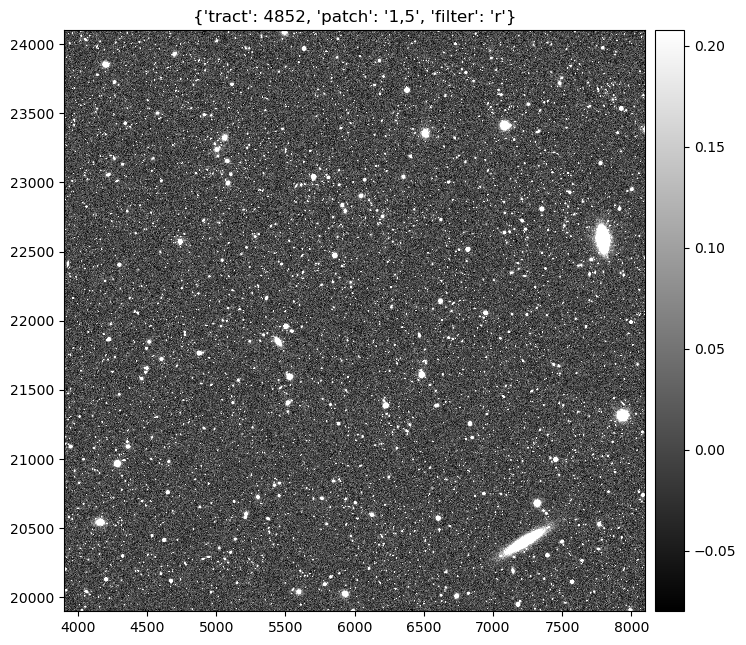

In [26]:
# Let's take a look at the full patch first
fig = plt.figure(figsize=(8, 8), dpi=100)
# Note that we set frame=1 below to allow afwDisplay to use the figure instance we created
display = afwDisplay.Display(1, backend='matplotlib')
display.scale("linear", "zscale")
display.mtv(full_patch.getMaskedImage().getImage())
#display.mtv(full_patch.getImage())
#plt.grid(color="w")
plt.title(dataId)

(21500, 22500)

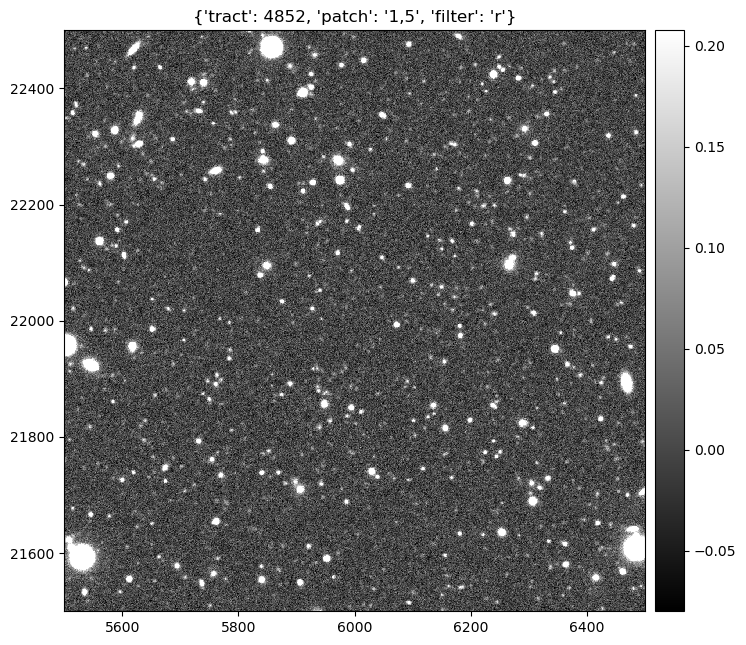

In [28]:
# Let's take a look at the full patch first
fig = plt.figure(figsize=(8, 8), dpi=100)
# Note that we set frame=1 below to allow afwDisplay to use the figure instance we created
display = afwDisplay.Display(1, backend='matplotlib')
display.scale("linear", "zscale")
display.mtv(full_patch.getMaskedImage().getImage())
#display.mtv(full_patch.getImage())
#plt.grid(color="w")
plt.title(dataId)
plt.xlim(5500,6500)
plt.ylim(21500,22500)

In [29]:
# get the numpy array
theimage_arr=full_patch.getMaskedImage().getImage().getArray()

In [135]:
theimage_arr.shape

(4200, 4200)

Text(0.5, 1.0, "{'tract': 4852, 'patch': '1,5', 'filter': 'r'}")

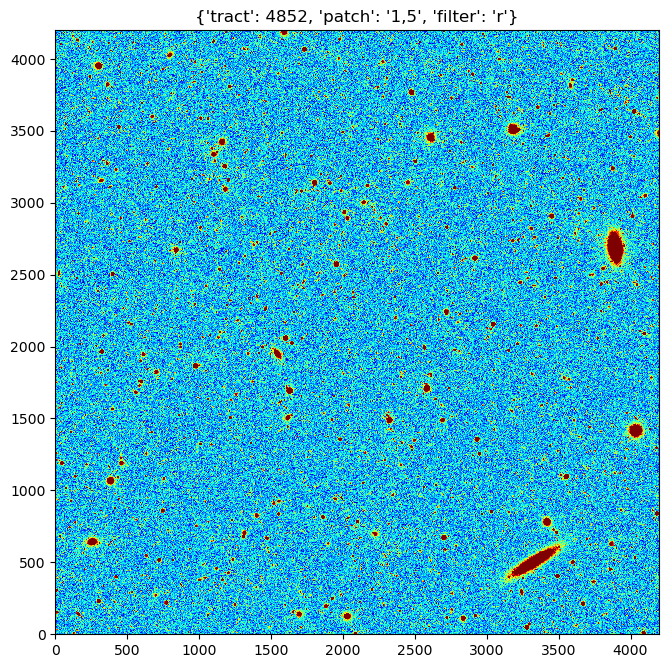

In [30]:
fig = plt.figure(figsize=(8, 8), dpi=100)
vmin, vmax = ZScaleInterval().get_limits(theimage_arr)
plt.imshow(theimage_arr,vmin=vmin, vmax=vmax,origin="lower",cmap="jet")
plt.title(dataId)

/opt/lsst/software/stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':


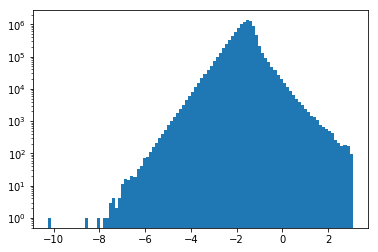

In [31]:
plt.hist(np.log10(theimage_arr.flatten()),bins=100);
plt.yscale('log')

### Make a postage stamp!

To make a postage stamp, we can simply use the `getCutout` method to obtain the cutout from the full patch data. 
We can also obtain WCS information so that we can show RA/Dec values on teh axes. 

Here we will use plain matplotlib to make our postage stamp, because I assume most people are more familar with matplotlib than `afw.display`! 
However, `afw.display` provides some useful functions and powerful integration with ds9 and others, if you get some time to learn it! 

In [145]:
# Define the center and size of our cutout
#radec = lsst.geom.SpherePoint(object_this["ra"], object_this["dec"], lsst.geom.degrees)
radec = lsst.geom.SpherePoint(ra0, dec0, lsst.geom.degrees)
cutout_size = 4200  # 300 pixels -> about 1 arcmin (we'll see why in a bit!)
cutout_extent = lsst.geom.ExtentI(cutout_size, cutout_size)

# Retrieve cutout
cutout = full_patch.getCutout(radec, cutout_extent)

# Retrieve wcs
wcs = cutout.getWcs()
print(wcs)
wcs_fits_meta = wcs.getFitsMetadata()
#print(wcs_fits_meta)

# Retrieve the image array
image_arr = cutout.getMaskedImage().getImage().array

FITS standard SkyWcs:
Sky Origin: (58.878505, -29.008264)
Pixel Origin: (13999, 13999)
Pixel Scale: 0.2 arcsec/pixel


In [146]:
image_arr.shape

(4200, 4200)

In [148]:
4200*0.2/60 # arcmin

14.0

https://docs.astropy.org/en/stable/wcs/wcsapi.html

In [140]:
WCS(wcs_fits_meta)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 58.87850467289716  -29.00826446280992  
CRPIX : 14000.0  14000.0  
CD1_1 CD1_2  : -5.5555555555587e-05  0.0  
CD2_1 CD2_2  : 0.0  5.55555555555879e-05  
NAXIS : 0  0

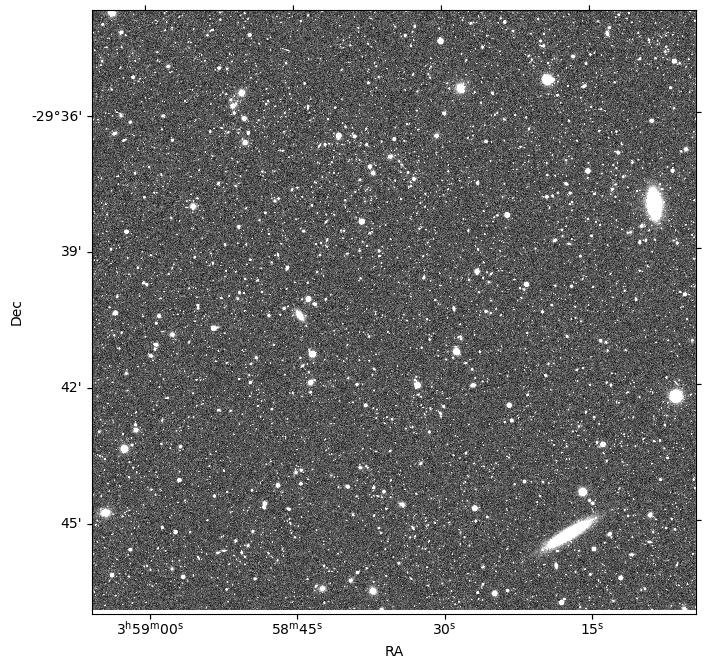

In [141]:
# make plot with astropy.wcs and matplotlib

fig, ax = plt.subplots(subplot_kw={'projection': WCS(wcs_fits_meta)}, figsize=(8, 8), dpi=100)

vmin, vmax = ZScaleInterval().get_limits(image_arr)
ax.imshow(image_arr, vmin=vmin, vmax=vmax, cmap='binary_r', origin='lower')

ax.set_xlabel("RA")
ax.set_ylabel("Dec")

#ax.axhline(dec0,color="r")
#ax.axvline(ra0,color="r")

In [69]:
c.dec.dms

dms_tuple(d=-28.0, m=-34.0, s=-12.000000000001023)

In [96]:
c.dec

<Latitude -28.57 deg>

In [70]:
c.ra.hms

hms_tuple(h=3.0, m=57.0, s=31.200000000003598)

In [95]:
c.ra

<Longitude 59.38 deg>

In [157]:
# Define the center and size of our cutout
#radec = lsst.geom.SpherePoint(object_this["ra"], object_this["dec"], lsst.geom.degrees)
radec = lsst.geom.SpherePoint(ra0, dec0, lsst.geom.degrees)
cutout_size = 600  # 300 pixels -> about 1 arcmin (we'll see why in a bit!)
cutout_extent = lsst.geom.ExtentI(cutout_size, cutout_size)

# Retrieve cutout
cutout = full_patch.getCutout(radec, cutout_extent)

# Retrieve wcs
wcs = cutout.getWcs()
print(wcs)
wcs_fits_meta = wcs.getFitsMetadata()
#print(wcs_fits_meta)

# Retrieve the image array
image_arr = cutout.getMaskedImage().getImage().array

FITS standard SkyWcs:
Sky Origin: (58.878505, -29.008264)
Pixel Origin: (13999, 13999)
Pixel Scale: 0.2 arcsec/pixel


In [158]:
image_arr.shape

(600, 600)

In [160]:
600*0.2/60 # arcmin

2.0

https://docs.astropy.org/en/stable/wcs/wcsapi.html

In [161]:
WCS(wcs_fits_meta)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 58.87850467289716  -29.00826446280992  
CRPIX : 14000.0  14000.0  
CD1_1 CD1_2  : -5.5555555555587e-05  0.0  
CD2_1 CD2_2  : 0.0  5.55555555555879e-05  
NAXIS : 0  0

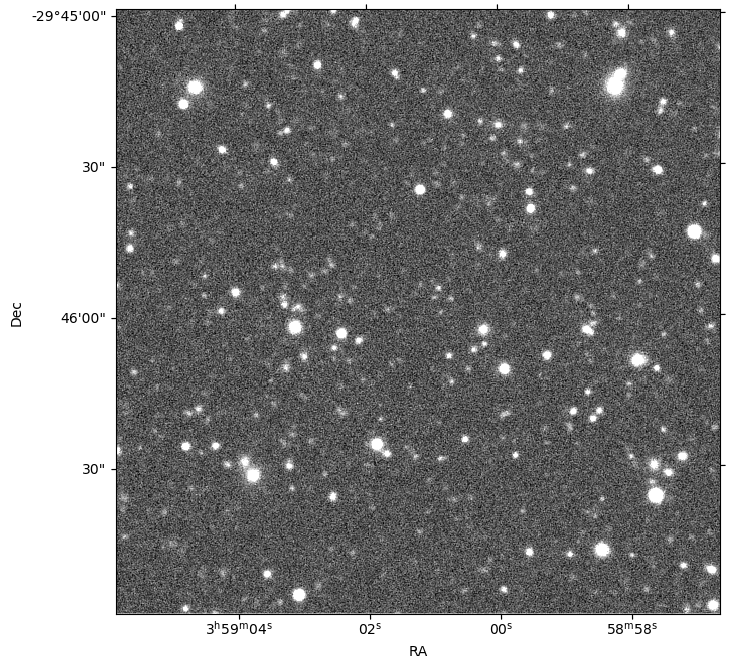

In [162]:
# make plot with astropy.wcs and matplotlib

fig, ax = plt.subplots(subplot_kw={'projection': WCS(wcs_fits_meta)}, figsize=(8, 8), dpi=100)

vmin, vmax = ZScaleInterval().get_limits(image_arr)
ax.imshow(image_arr, vmin=vmin, vmax=vmax, cmap='binary_r', origin='lower')

ax.set_xlabel("RA")
ax.set_ylabel("Dec")

#ax.axhline(dec0,color="r")
#ax.axvline(ra0,color="r")

### A different way to load cutout image by specifying a bbox

In [163]:
center = skymap.findTract(radec).getWcs().skyToPixel(radec)
bbox = lsst.geom.BoxI(lsst.geom.Point2I((center.x - cutout_size*0.5, center.y - cutout_size*0.5)), cutout_extent)

# Note the postfix `_sub` added to the dataset type!! Note how we skip the `full_patch` step here! 
cutout = butler.get("deepCoadd_sub", dataId=dataId, bbox=bbox)

wcs_fits_meta = cutout.getWcs().getFitsMetadata()
image_arr = cutout.getMaskedImage().getImage().array

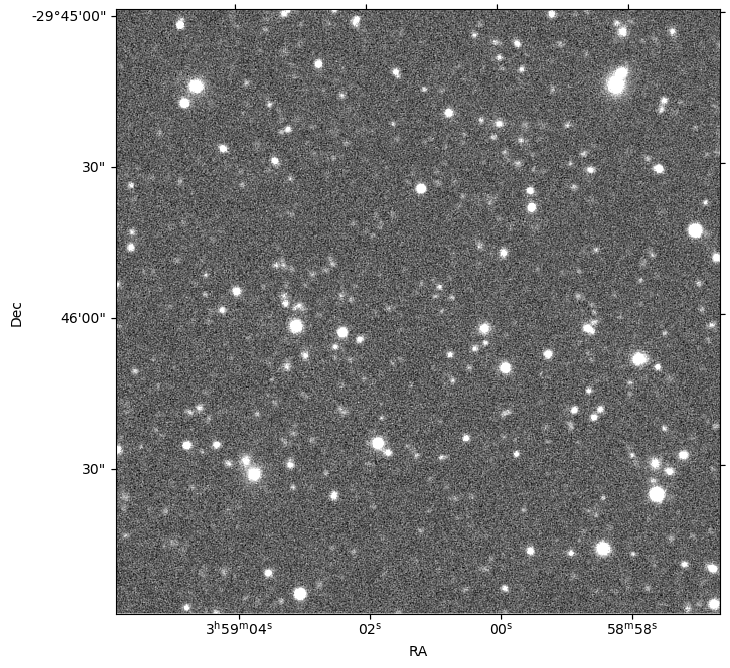

In [164]:
# We should obtain the same image as above! 

fig, ax = plt.subplots(subplot_kw={'projection': WCS(wcs_fits_meta)}, figsize=(8, 8), dpi=100)

vmin, vmax = ZScaleInterval().get_limits(image_arr)
ax.imshow(image_arr, vmin=vmin, vmax=vmax, cmap='binary_r', origin='lower')

ax.set_xlabel("RA")
ax.set_ylabel("Dec")

With the bbox method, we can make the loading time shorter (usually 2-3x speed up). 
This is useful when you need to make many cutouts! 

In [165]:
%%timeit
cutout = butler.get("deepCoadd", dataId=dataId).getCutout(radec, cutout_extent)

2.4 s ± 72.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [166]:
%%timeit
cutout = butler.get("deepCoadd_sub", dataId=dataId, bbox=bbox)

1.06 s ± 29.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Make a false color RGB image

Now we have all the tools to make a false color RGB image. We will need to load in images from three bands. Here we will use g, r, and i bands. We then can use `lsst.afw.display.rgb.makeRGB` to generate the false color image.

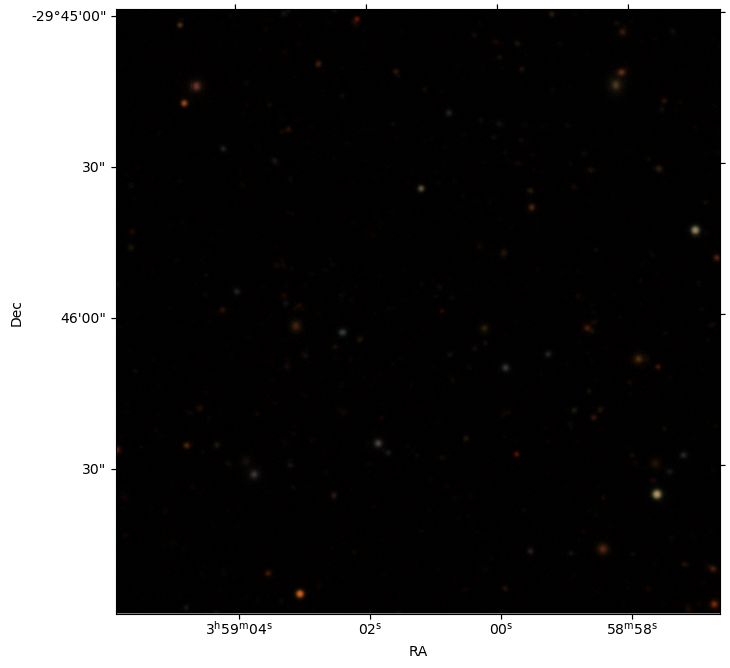

In [167]:
# Note how we directly supply keyword arguments instead of a single dataId dictionary here
# Also note the band ordering. We will use "irg" for "RGB", respectively. 
#cutouts = [butler.get("deepCoadd_sub", bbox=bbox, tract=object_this["tract"], patch=object_this["patch"], filter=band) for band in "irg"]
cutouts = [butler.get("deepCoadd_sub", bbox=bbox, tract=4852, patch='1,5', filter=band) for band in "irg"]


wcs_fits_meta = cutouts[0].getWcs().getFitsMetadata()
image_rgb = rgb.makeRGB(*cutouts)
del cutouts  # let gc save some memory for us

fig, ax = plt.subplots(subplot_kw={'projection': WCS(wcs_fits_meta)}, figsize=(8, 8), dpi=100)
ax.imshow(image_rgb, origin='lower')
ax.set_xlabel("RA")
ax.set_ylabel("Dec")
#ax.set_axhline(dec0)

Nice image, right? And it appears to be a blended object with a miscentering! 

## Yay! Let's put this all together now! 

This final cell is going to take a bit longer (about 50-60 seconds) 

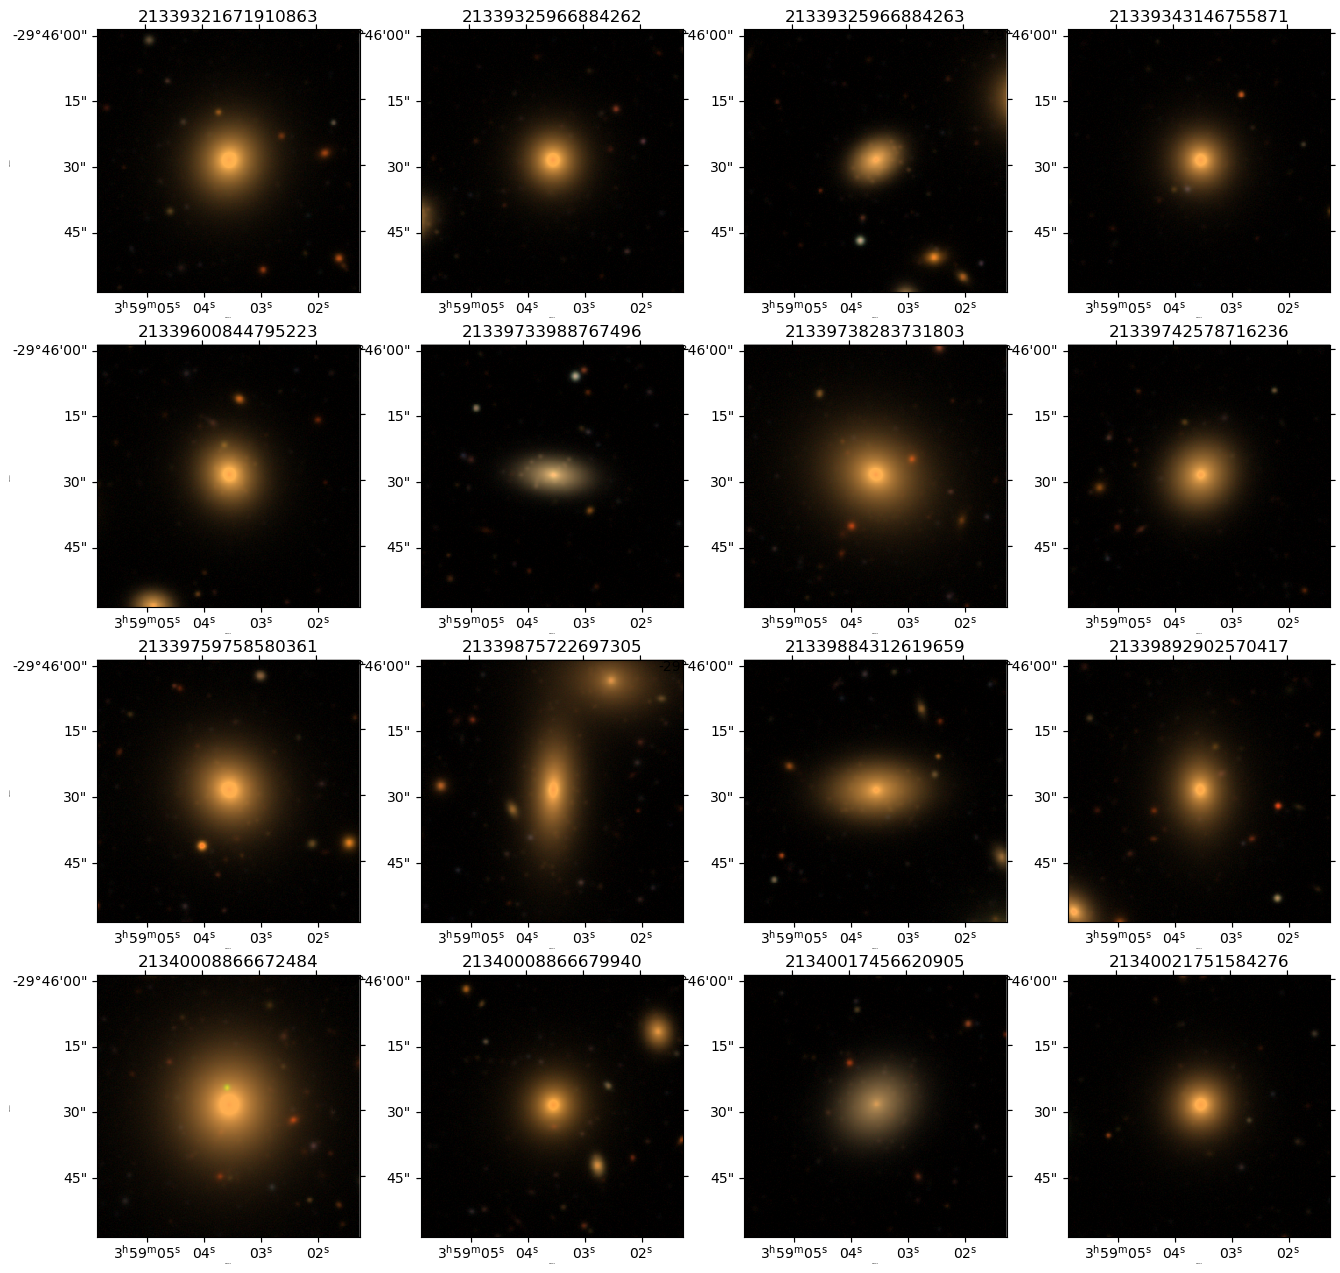

In [168]:
fig = plt.figure(figsize=(16, 16), dpi=100)
gs = plt.GridSpec(4, 4, fig)

cutout_size = 300
cutout_extent = lsst.geom.ExtentI(cutout_size, cutout_size)

for (_, object_this), gs_this in zip(objects.iterrows(), gs):
    radec = lsst.geom.SpherePoint(object_this["ra"], object_this["dec"], lsst.geom.degrees)
    #radec = lsst.geom.SpherePoint(ra0, dec0, lsst.geom.degrees)
    center = skymap.findTract(radec).getWcs().skyToPixel(radec)
    bbox = lsst.geom.BoxI(lsst.geom.Point2I((center.x - cutout_size*0.5, center.y - cutout_size*0.5)), cutout_extent)

    cutouts = [butler.get("deepCoadd_sub", bbox=bbox, tract=object_this["tract"], patch=object_this["patch"], filter=band) for band in "irg"]
    wcs_fits_meta = cutouts[0].getWcs().getFitsMetadata()
    image_rgb = rgb.makeRGB(*cutouts)
    del cutouts  # let gc save some memory for us

    ax = plt.subplot(gs_this, projection=WCS(wcs_fits_meta), label=str(object_this["objectId"]))
    ax.imshow(image_rgb, origin='lower')
    ax.set_title(str(object_this["objectId"]))
    del image_rgb  # let gc save some memory for us
    
    for c in ax.coords:
        c.set_ticklabel(exclude_overlapping=True, size=10)
        c.set_axislabel('', size=0)
